## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
!nvidia-smi

Fri Mar 11 11:35:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from tensorflow import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 256)               786688    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 256)               65792 

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

def CreateOptimizer(opt, LEARNING_RATE, MOMENTUM):
    if opt == "SGD":
        return keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    if opt == "Adam":
        return keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    if opt == "RMSProp":
        return keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

optimizer_set = ["SGD", "Adam", "RMSProp"]

"""
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1]
reduce_lr_patient = [5, 10]

In [9]:
import itertools

results = {}

for i, (opt, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, 
                                                                           reduce_lr_factor, 
                                                                           reduce_lr_patient)):
    keras.backend.clear_session()
    
    exp_name_tag = f"Opt-{opt}, reduce_factor-{reduce_factor:.1f}, reduce_patient-{reduce_patient:1d}"
    
    print(f"===== Exp: {exp_name_tag} =====")
    
    model = build_mlp(input_shape=x_train.shape[1:])
    
    model.compile(loss="categorical_crossentropy", 
                  metrics=["accuracy"], 
                  optimizer=CreateOptimizer(opt, LEARNING_RATE, MOMENTUM))
    
    # 設定 reduce learning rate 的 callback function
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12,
                                  monitor='val_loss',
                                  patience=reduce_patient,
                                  verbose=1)
    
    history = model.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_data=(x_test, y_test), 
                        shuffle=True,
                        callbacks=[reduce_lr], 
                        verbose=0)

    # Collect results
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

===== Exp: Opt-SGD, reduce_factor-0.5, reduce_patient-5 =====

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 45: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 50: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
===== Exp: Opt-SGD, reduce_factor-0.5, reduce_patient-10 =====

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
===== Exp: Opt-SGD, reduce_factor-0.1, reduce_patient-5 =====

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 38: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 48: ReduceLROnPlateau re

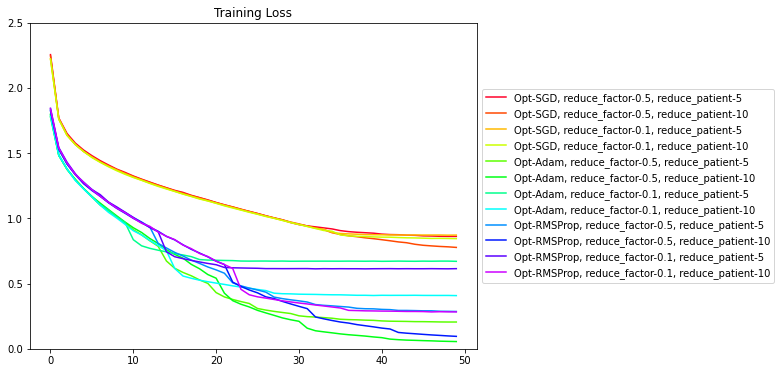

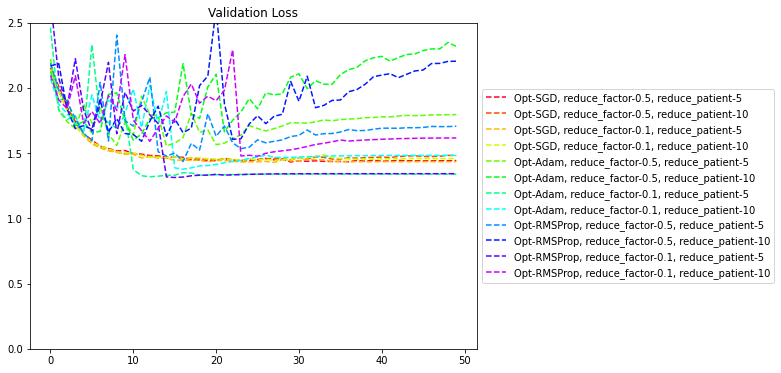

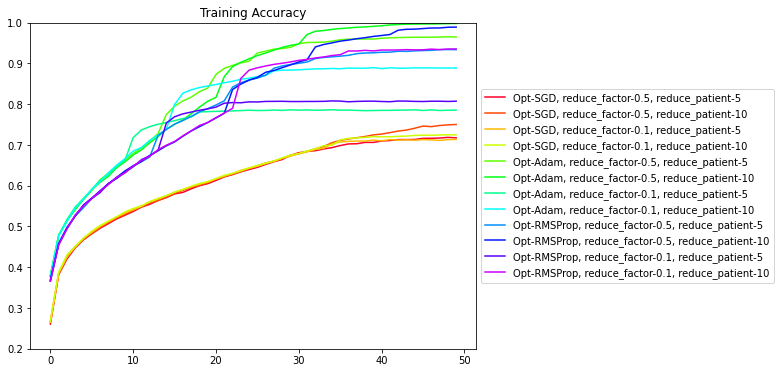

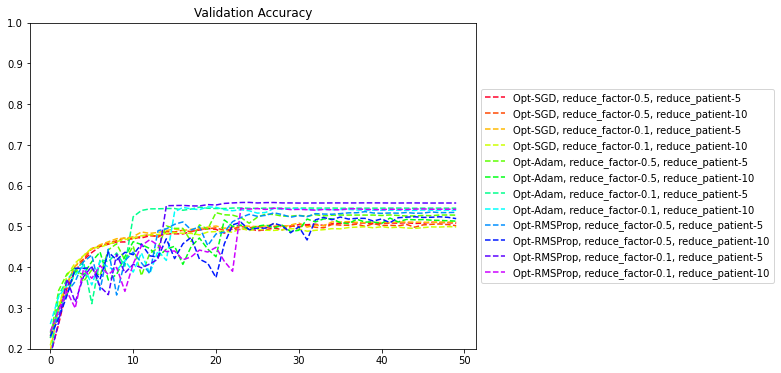

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Loss")
plt.ylim([0, 2.5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Loss")
plt.ylim([0, 2.5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Accuracy")
plt.ylim([0.2, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Accuracy")
plt.ylim([0.2, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()